In [14]:
%matplotlib inline
import scipy.special as sp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize,least_squares

In [2]:
# Parameters
v0=8.0
nwind = 33
wind=np.arange(254,287)
#b=np.array((1,5,1000))
b=np.array(( 1.40002561e-01,   8.51478121e+00,   2.62606729e+03))

In [3]:
#Simple Attenuation fn
def att(dist, ang, b):
    # angular part
    angular=np.where(b[1]*np.abs(ang)<np.pi/2.,np.square(np.cos(b[1]*ang)),0.)
    #radial
    radial=np.exp(-np.square(dist/b[2]))
    return 1.0-b[0]*angular*radial

In [4]:
#Loading the wind velocities for each wind turbine and each angle from CFD data
v=np.loadtxt('hornsrev_data_all.txt')
vxref=v[:,3]
vyref=v[:,4]
angles=v[:,0]
#Calculating the mean wind velocities from x and y coordinates
vmean=np.sqrt(np.square(vxref)+np.square(vyref))
vmean=pd.DataFrame(vmean)
vref=pd.DataFrame()
vmean['angle']=angles
vref=vref.append(vmean)
#Seperating the wind speed appropriate to the wind angles
vref=vref.groupby('angle')
vref.groups
vref.describe()
#vref.get_group(260).iat[50,0]
#vref.iat[5,0]
#vref.groupby('angle')


6.512913707119303

In [7]:
#Loading the coordinates of each wind turbine 
coords_in = np.loadtxt('coords.txt')
#Calculating the min points of the wind turbines
xmin = min(coords_in[:,0])
ymin = min(coords_in[:,1])
#Finding a central point for whole wind farm
xzero = (max(coords_in[:,0])-xmin)/2
yzero = (max(coords_in[:,1])-ymin)/2
#print(xzero, yzero)
#Putting wind turbines appropriate to the new centre point
coords_x=coords_in[:,0]-xzero-xmin
coords_y=coords_in[:,1]-yzero-ymin
coords=[coords_x,coords_y]
coords=np.array(coords).T
nturb=np.shape(coords)[0]
#plt.scatter(coords[:,0], coords[:,1])

#Arrays for pairwise distances and angles
#Angle 0: x direction. Angle pi/2: y direction
distance=np.zeros((nturb,nturb))
angle=np.zeros((nturb,nturb))
for i in range(0,nturb):
    distance[i,:]=np.sqrt(np.square(coords[i,0]-coords[:,0])+np.square(coords[i,1]-coords[:,1]))
    angle[i,:]=np.arctan2(coords[:,1]-coords[i,1],coords[:,0]-coords[i,0])
#Rotate angles so that north=0 and convert to degrees
angle=-np.rad2deg(angle)+270
angle[0,1]

#Rotating angles to wind direction
windangle=5 #degrees
rotangles=np.mod(angle-windangle+180,360)-180

(np.sort(distance))[0,2]

561.1105060502788

In [8]:
i=0
j=8
print('Turbine {} x {} y {}'.format(i,coords[i,0],coords[i,1]))
print('Turbine {} x {} y {}'.format(j,coords[j,0],coords[j,1]))
print('{}-{} dist {} angle {}'.format(i,j,distance[i,j], angle[i,j]))

Turbine 0 x -2728.5 y 1952.0
Turbine 8 x -2168.5 y 1952.0
0-8 dist 560.0 angle 270.0


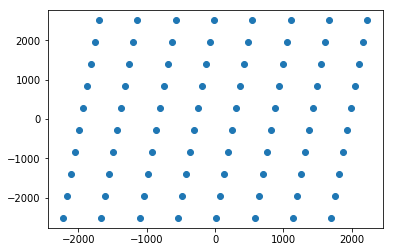

In [9]:
def rotate(angle,coords):
    angle = np.pi*angle/180.
    rotcoordx = []
    rotcoordy = []
    for coord in coords:
        rotcoordx+=[coord[0]*np.cos(angle)-coord[1]*np.sin(angle)]
        rotcoordy+=[coord[0]*np.sin(angle)+coord[1]*np.cos(angle)]
    rotcoords=[rotcoordx,rotcoordy]
    rotcoords=np.array(rotcoords).T   
    return rotcoords 
#print rotate(254,coords)[:,0]
plt.scatter(rotate(264,coords)[:,0],rotate(264,coords)[:,1])

In [10]:
#Total att
def deviation(b):
    total_att=np.ones((nturb,nwind))
    deviation=0
    for k in range(0,nwind):
        for j in range(0,nturb):
            for i in range(0,nturb):
                if (i!=j):
                    total_att[j,k] = total_att[j,k]*att(distance[i,j],np.mod(np.deg2rad(angle[i,j]-wind[k])+np.pi,np.pi*2)-np.pi,b)
 #           print('{0} {1} {2}'.format(j,wind[k],total_att[j,k]))
            deviation=deviation+np.square(vref.get_group(wind[k]).iat[j,0]-v0*total_att[j,k])
    return deviation

In [13]:
#Total att
def deviation_sq(b):
    total_att=np.ones((nturb,nwind))
    dev_vec=np.zeros((nturb*nwind))
    for k in range(0,nwind):
        for j in range(0,nturb):
            for i in range(0,nturb):
                if (i!=j):
                    total_att[j,k] = total_att[j,k]*att(distance[i,j],np.mod(np.deg2rad(angle[i,j]-wind[k])+np.pi,np.pi*2)-np.pi,b)
 #           print('{0} {1} {2}'.format(j,wind[k],total_att[j,k]))
            dev_vec[nturb*k+j]=(vref.get_group(wind[k]).iat[j,0]-v0*total_att[j,k])
    return dev_vec

[[1.         1.         1.         ... 0.57421312 0.57835346 0.50096564]
 [1.         1.         1.         ... 0.58587949 0.58899062 0.59225709]
 [1.         1.         1.         ... 0.61844562 0.61914042 0.62021525]
 ...
 [1.         1.         1.         ... 0.62159613 0.61933755 0.61778019]
 [1.         1.         1.         ... 0.57189015 0.57355987 0.57564542]
 [0.85999744 0.8600127  0.86005849 ... 0.55131572 0.55536028 0.55943108]]


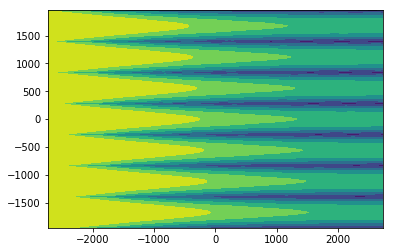

In [11]:
#Plot attenuation
xsamp = np.linspace(min(coords_x), max(coords_x), 200)
ysamp = np.linspace(min(coords_y), max(coords_y), 200)

x,y = np.meshgrid(xsamp,ysamp)
distances=np.empty_like(x)
angles=np.empty_like(x)
values=np.empty_like(x)
values=1.0

for j in range(0,nturb):
    distances=np.sqrt(np.square(coords[j,0]-x)+np.square(coords[j,1]-y))
    angles=np.arctan2(y-coords[j,1],x-coords[j,0])+0/180*np.pi
    values = values*att(distances,angles,b) #np.mod(angles-wind[k]+np.pi,np.pi*2)-np.pi,b)

print(values)

#-- Plot... ------------------------------------------------
fig, ax = plt.subplots()
ax.contourf(x, y, values)

plt.show()

In [129]:
#Unconstrained minimisation
res=minimize(deviation,b)


In [15]:
#Least squares minimisation
lsq=least_squares(deviation_sq,b,method='lm')

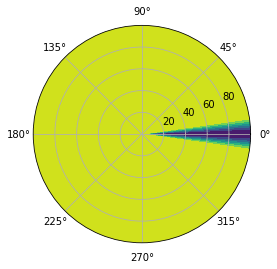

In [12]:
azimuths = np.radians(np.linspace(-180, 180, 360))
zeniths = np.arange(0, 100, .1)

r, theta = np.meshgrid(zeniths, azimuths)
values = att(r,theta,b)

#-- Plot... ------------------------------------------------
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
ax.contourf(theta, r, values)

plt.show()

In [16]:
lsq

 active_mask: array([0, 0, 0])
        cost: 346.62600152398227
         fun: array([-0.43111623, -0.23196619, -0.46045137, ..., -0.14973647,
       -0.31511648, -0.31754505])
        grad: array([ 3.77098865e-03, -1.64768308e-03, -4.17687333e-07])
         jac: array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 1.11185350e+01, -1.69012193e-01,  1.35304027e-03],
       [ 1.11116172e+01, -1.68967333e-01,  1.35201293e-03],
       [ 1.11257356e+01, -1.70529929e-01,  1.35145501e-03]])
     message: '`ftol` termination condition is satisfied.'
        nfev: 5
        njev: None
  optimality: 0.0037709886544234905
      status: 2
     success: True
           x: array([1.39998719e-01, 8.51483871e+00, 2.62613638e+03])

In [17]:
b

array([1.40002561e-01, 8.51478121e+00, 2.62606729e+03])

In [21]:
res=np.reshape(lsq.fun,(nwind,nturb))

In [22]:
print res

[[-0.43111623 -0.23196619 -0.46045137 ... -0.0982205  -0.33481943
  -0.68489314]
 [-0.42325345 -0.38578134 -0.41003802 ... -0.22453381 -0.38894206
  -0.53253668]
 [-0.40459057 -0.34337667 -0.42120008 ... -0.15328012 -0.52330292
  -0.53868485]
 ...
 [-0.23622915 -0.58586897 -0.29943877 ... -0.1556825  -0.40571253
  -0.38158218]
 [-0.21666345 -0.59795412 -0.46821978 ... -0.23238497 -0.33453279
  -0.32573417]
 [-0.23560898 -0.61350412 -0.48893564 ... -0.14973647 -0.31511648
  -0.31754505]]
